[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/davanstrien/fastai4GLAMS/blob/master/lessons/01_lesson/01_segmentation_herbarium.ipynb)

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.8MB/s 
     |████████████████████████████████| 1.0MB 10.1MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 194kB 24.2MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 40kB 7.1MB/s 
     |████████████████████████████████| 92kB 11.5MB/s 
     |████████████████████████████████| 40kB 7.1MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 2.6MB 21.4MB/s 
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.vision.all import *

In [ ]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

# Fern Segmentation

In this notebook I'm going to try and use `fastai` to build the U-Net model for segmenting images of fern specimens, reported in [this paper by White *et al*](https://doi.org/10.1002/aps3.11352) from the Smithsonian/BYU.

The paper describes their whole process for generating masks to extract just the specimen from a specimen image. Their process involves:

1. Select 400 high resolution images that represent the breadth of shape diversity of the fern specimens by selecting them at random, removing ones they don't want, then repeating. 
2. Import the images as greyscale and then use Otsu's binarisation to automatically pick the best intensity threshold for making the image black and white.
3. Take the foreground images (white specimen, black background) and remove any background noise or labels or colour palettes using photo editing software.
4. Tidy the edited masks up to remove any bits that became greyscale during editing.
5. Use a blur to remove any final disparities.
6. Train a U-Net style model to do the segmentation, using an 80/20 validation split.
7. Use the trained model to generate masks for new images.

It's a pretty involved process to make the masks needed for training, but luckily the authors provided the original images and masks used to train their net, so we can just focus on the model.

I think this a good example to do a quick segmentation problem, like the one demonstrated in [Lesson 1]() of the `fastai` course.

## Getting the data

All of their data is on figshare in different files, so we can just download it from there.



### Specimen images

The 400 specimen images are all in a zip folder, which we can download.

In [ ]:
! wget https://smithsonian.figshare.com/ndownloader/files/17851235 -O images.tar.gz

--2020-10-01 09:05:06--  https://smithsonian.figshare.com/ndownloader/files/17851235
Resolving smithsonian.figshare.com (smithsonian.figshare.com)... 34.247.3.232, 52.214.89.34
Connecting to smithsonian.figshare.com (smithsonian.figshare.com)|34.247.3.232|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3.us-east-2.amazonaws.com/pstorage-si-9094369797/17851235/original_hires_images.tar.gz [following]
--2020-10-01 09:05:06--  https://s3.us-east-2.amazonaws.com/pstorage-si-9094369797/17851235/original_hires_images.tar.gz
Resolving s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)... 52.219.84.186
Connecting to s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)|52.219.84.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4650249542 (4.3G) [application/gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>]   4.33G  43.3MB/s    in 1m 40s  

2020-10-01 09:06:47 (44.1 MB/s) - ‘images.tar.gz’

In [ ]:
%%capture
! tar -xf images.tar.gz
! rm images.tar.gz

Let's just check how many images were downloaded.

In [ ]:
print(f"Downloaded {len(os.listdir('original_hires_images'))} specimen images")

Downloaded 800 specimen images


This is too many? Let's have a look at the names of some of them.

In [ ]:
os.listdir('original_hires_images')[:10]

['01453724.jpg',
 '01407575.jpg',
 '01398054.jpg',
 '._01414617.jpg',
 '._01397612.jpg',
 '._01413072.jpg',
 '01424122.jpg',
 '01448356.jpg',
 '00763411.jpg',
 '._01444412.jpg']

Looks like there are two naming conventions - some start with `._` and some don't. Possibly some sort of artefact image? Let's have a look at one of each.

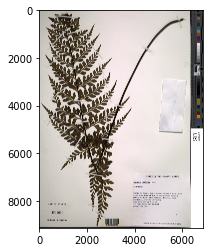

In [ ]:
image_file1 = "original_hires_images/00458015.jpg"
im1 = Image.open(image_file1)
plt.imshow(np.asarray(im1));

In [ ]:
image_file2 = "original_hires_images/._00458015.jpg"
try:
  im2 = Image.open(image_file2)
  plt.imshow(np.asarray(im1))
except:
  print("Could not load file - doesn't seem to be an image")

Could not load file - doesn't seem to be an image


We get an error with the second one! So I think they are some kind of artifact, and we do not want them. So I'll get rid.

In [ ]:
ghost_files = [path for path in os.listdir("original_hires_images") if path.startswith("._")]
for path in ghost_files:
  os.remove(f"original_hires_images/{path}")

print(f"Are there any ghost files remaining? {any([path.startswith('._') for path in os.listdir('original_hires_images')])}")

Are there any ghost files remaining? False


### Masks

The deal is the same for the masks that they made - they're hosted on Figshare as a tar file, so we can just grab them.

In [ ]:
! wget https://smithsonian.figshare.com/ndownloader/files/17851277 -O masks.tar.gz

--2020-10-01 09:17:38--  https://smithsonian.figshare.com/ndownloader/files/17851277
Resolving smithsonian.figshare.com (smithsonian.figshare.com)... 52.214.89.34, 34.247.3.232
Connecting to smithsonian.figshare.com (smithsonian.figshare.com)|52.214.89.34|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3.us-east-2.amazonaws.com/pstorage-si-9094369797/17851277/hires_masks.tar.gz [following]
--2020-10-01 09:17:38--  https://s3.us-east-2.amazonaws.com/pstorage-si-9094369797/17851277/hires_masks.tar.gz
Resolving s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)... 52.219.104.178
Connecting to s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)|52.219.104.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341389472 (326M) [application/gzip]
Saving to: ‘masks.tar.gz’

masks.tar.gz        100%[===================>] 325.57M  39.2MB/s    in 7.9s    

2020-10-01 09:17:47 (41.2 MB/s) - ‘masks.tar.gz’ saved [341389472/341

In [ ]:
%%capture
! tar -xf masks.tar.gz
! rm masks.tar.gz

And then let's check how many images we have again.

In [ ]:
print(f"Downloaded {len(os.listdir('hires_masks'))} mask images")

Downloaded 800 mask images


Same thing as before, with the ghost image files.

In [ ]:
os.listdir("hires_masks")[:10]

['01417369_mask.jpg',
 '01425957_mask.jpg',
 '01402585_mask.jpg',
 '01447827_mask.jpg',
 '._01421622_mask.jpg',
 '00943168_mask.jpg',
 '01399672_mask.jpg',
 '01398892_mask.jpg',
 '._01412623_mask.jpg',
 '._01395757_mask.jpg']

So let's delete them.

In [ ]:
ghost_files = [path for path in os.listdir("hires_masks") if path.startswith("._")]
for path in ghost_files:
  os.remove(f"hires_masks/{path}")

print(f"Are there any ghost files remaining? {any([path.startswith('._') for path in os.listdir('hires_masks')])}")

Are there any ghost files remaining? False


### Specimen info

As well as the images and masks, the authors provide some metadata about the specimens, including the catalogue reference, taxonomy, and collection info.

We can just load this in as a `DataFrame`.

In [ ]:
specimen_info = pd.read_csv("https://smithsonian.figshare.com/ndownloader/files/21488406", sep="\t", index_col=0)
specimen_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   irn                 400 non-null    int64  
 1   CatBarcode          400 non-null    int64  
 2   CatalogNumber       400 non-null    object 
 3   Class               400 non-null    object 
 4   Order               400 non-null    object 
 5   Family              400 non-null    object 
 6   Genus               400 non-null    object 
 7   SpecificEpithet     399 non-null    object 
 8   ScientificName      400 non-null    object 
 9   Country             400 non-null    object 
 10  YearCollected       363 non-null    float64
 11  Collector           400 non-null    object 
 12  valid_set_equals_1  400 non-null    int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 43.8+ KB


## Looking at the data

Before we get on to training the model, let's have a quick look at the data.

We'll have a look at the metadata first, at where and when the specimens were collected, and what family the specimens are in.

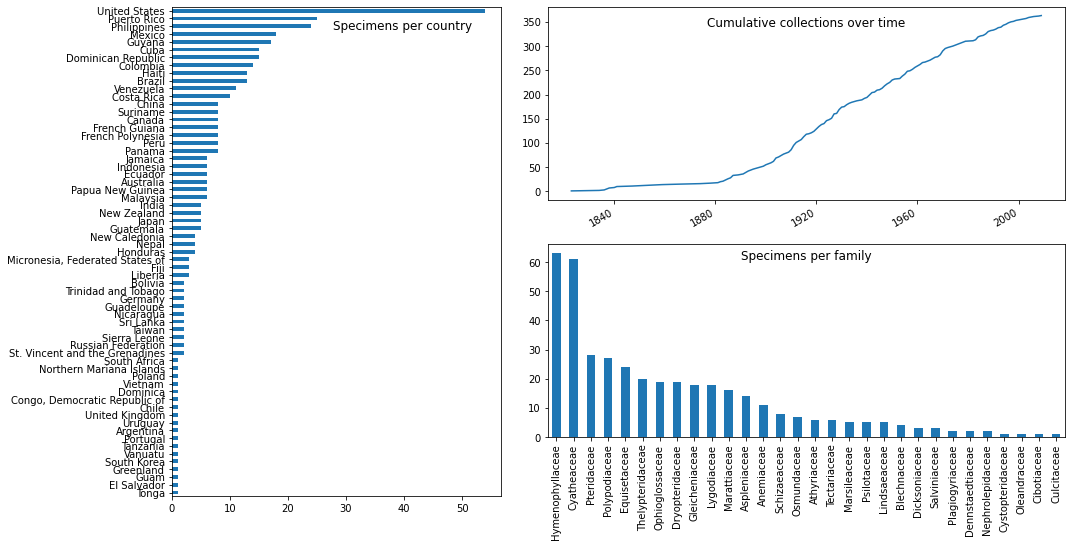

In [ ]:
fig = plt.figure(figsize=(16, 10))

grid = gs.GridSpec(ncols=10, nrows=9, figure=fig)

ax1 = fig.add_subplot(grid[:, :4])
ax2 = fig.add_subplot(grid[:4, 4:])
ax3 = fig.add_subplot(grid[4:8, 4:])

specimen_info.Family.value_counts().plot.bar(ax=ax3)
ax3.text(0.5, 0.975, "Specimens per family", 
         transform=ax3.transAxes, ha="center", va="top", fontsize=12)

specimen_info.Country.value_counts().plot.barh(ax=ax1)
ax1.text(0.7, 0.975, "Specimens per country", 
         transform=ax1.transAxes, ha="center", va="top", fontsize=12)

(
    specimen_info.assign(YearCollected=lambda df: pd.to_datetime(df.YearCollected, format="%Y"))
      .YearCollected.value_counts()
      .reset_index(name="n")
      .rename(columns={"index": "YearCollected"})
      .sort_values(by="YearCollected")
      .assign(cumsum=lambda df: df.n.cumsum())
).plot(x="YearCollected", y="cumsum", legend=False, ax=ax2)

ax2.set_xlabel("")
ax2.text(0.5, 0.95, "Cumulative collections over time", transform=ax2.transAxes, ha="center", va="top", fontsize=12)
ax1.invert_yaxis()

fig.subplots_adjust(hspace=3, wspace=1);

Like the paper describes, the 400 example specimens are from ~30 families, with most in `Hymenophyllaceae`, `Cyatheaceae`, `Pteridaceae`, and `Polypodiaceae`. Pretty unsurprisingly, as this is from the Smithsonian collection, most specimens were collected in current and former US territories. A majority of the specimens are from the Americas.

In terms of time, it looks like there was slow accumulation of specimens prior to 1900, with fairly steady growth throughout the 20th century, and then collecting slowed down a bit coming up to present day.

This is a fairly tight set of specimens in terms of geography and time, so most of them *should* be in a similar state and prepared in a similar-ish way.

Finally, let's have a look at some of the specimens and their masks, just to get a feel for it.

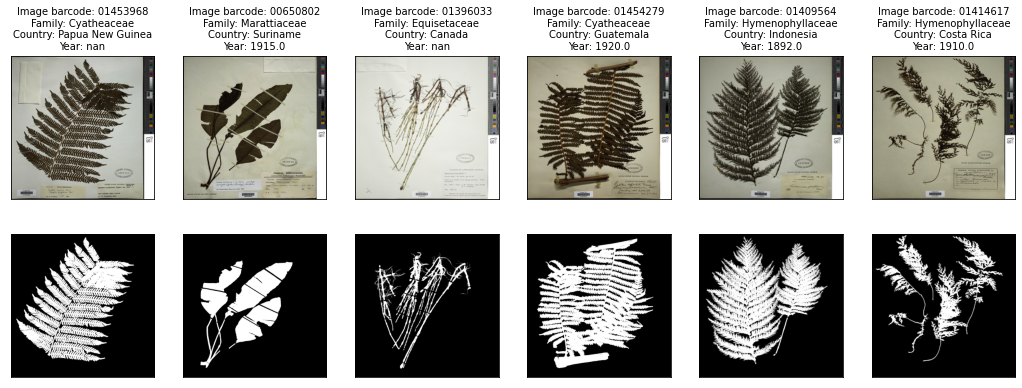

In [ ]:
specimen_sample = specimen_info.sample(6).to_dict(orient="records")

img_size = (256,256)

fig, axes = plt.subplots(figsize=(18,6), nrows=2, ncols=6) 

for i, sample in enumerate(specimen_sample):

  barcode = f"{sample['CatBarcode']:08}"

  specimen_img = Image.open(f"original_hires_images/{barcode}.jpg").resize(img_size, Image.ANTIALIAS)
  mask_img = Image.open(f"hires_masks/{barcode}_mask.jpg").resize(img_size, Image.ANTIALIAS)
  
  axes[0,i].imshow(np.asarray(specimen_img))
  axes[1,i].imshow(np.asarray(mask_img), cmap="Greys_r")

  title = [f"Image barcode: {barcode}",
           f"Family: {sample['Family']}",
           f"Country: {sample['Country']}",
           f"Year: {sample['YearCollected']}"]

  axes[0,i].set_title("\n".join(title), fontsize=10)
  
for ax in axes.ravel():
  ax.set_xticks([])
  ax.set_yticks([])



This looks like a pretty good range of forms, just in this small sample, and the masks look really good.

## Training a model

Now we can use these images to train our U-Net style model.


### Preparing the data for training

To put the data through the model, we need to put it in some kind of data loader.

The authors also do some pre-processing to the images, but we'll try it without augmentation first. 

Looking at the example in [lesson 1](https://github.com/fastai/fastbook/blob/master/01_intro.ipynb) of `fastai`, we need to set up a `SegmentationDataLoaders` object.

This takes an argument specifying how to get the image paths, and another that specifies how to get the mask paths.

For the image paths, we can just use the `get_image_files` function.

original_hires_images/01453724.jpg


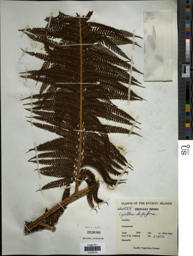

In [ ]:
path = Path("./")

img_paths = get_image_files(path/"original_hires_images")
img = Image.open(img_paths[0])
print(img_paths[0])
img.to_thumb(256,256)

For the mask paths, we provide a `lambda` function that can map our image path to the appropriate mask path.

hires_masks/01453724_mask.jpg


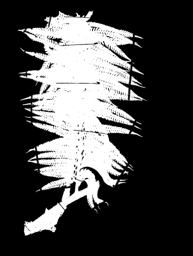

In [ ]:
label_func = lambda o: path/f'hires_masks/{o.stem}_mask{o.suffix}'
mask_path = label_func(img_paths[0])
img = Image.open(mask_path)
print(mask_path)
img.to_thumb(256,256)

The `SegmentationDataLoaders` object takes another bit of info, which is a list of codes for items in the images to segment. I think we can just create this in this notebook as `Specimen` and `Sheet`?

I have a feeling the indices of the codes need to align with the ordinal pixel numbers for the classes we are predicting - so in this image, the `Sheet` corresponds to 0 and the `Specimen` has a pixel value of 1, so `Sheet` comes first then `Specimen`.

In [ ]:
codes = np.array(["Sheet", "Specimen"], dtype=str)
codes

array(['Sheet', 'Specimen'], dtype='<U8')

And now let's set up the loader. There are a couple of other things that I needed to sort out to get this to work properly:
* Provide a path to the data folder that contains our images and our masks, as a `Path` object.
* Provide a batch size.
* Provide `Resize` transformation to make sure all the images are loaded as the same size. I've given this in the `item_tfms` keyword argument because I think we want to apply this transform to each image before they're batched up and given to the GPU. It also needs to be given as a `list`, even if we're only applying a single transform.
* Provide a transformation to make sure our mask pixel values are either 0 or 1. They're actually stored in our mask files as 0 and 255. So I've used the `IntToFloatTensor` transform and used the `div_mask` argument to divide all our mask pixel values by 255. I've given this in the `batch_tfms` argument because I think it's more efficient to do this in the GPU? I don't know really, I saw it in a blog.

With all that sorted, we can create the data loader and look at one batch of images.

In [ ]:
path = Path("./")
batch_size = 10
size = 256

dls = SegmentationDataLoaders.from_label_func(
    path,
    bs=batch_size,
    fnames=get_image_files(path/"original_hires_images"),
    label_func=lambda o: path/f'hires_masks/{o.stem}_mask{o.suffix}',
    codes=codes,
    item_tfms=[Resize(size, pad_mode=PadMode.Border)],
    batch_tfms=[IntToFloatTensor(div_mask=255)],
    valid_pct=0.2
)

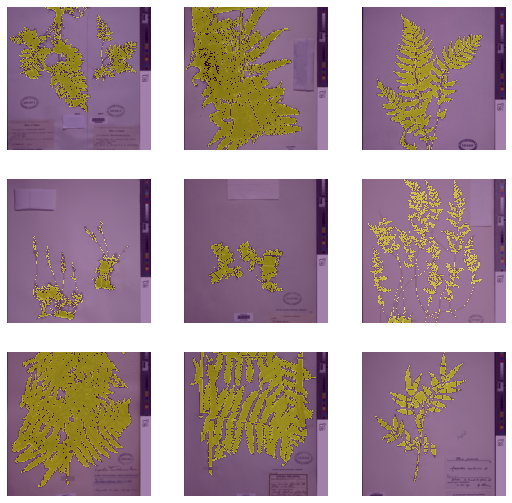

In [ ]:
dls.show_batch(cmap="viridis", vmin=0, vmax=1)

### Training the model

To train the model, we can use the same pre-trained `resnet34` the original authors did and fine-tune it.

In [ ]:
segmenter = unet_learner(dls, resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
segmenter.fine_tune(8)

epoch,train_loss,valid_loss,time
0,0.345072,0.130148,07:29


epoch,train_loss,valid_loss,time
0,0.086954,0.067104,07:18
1,0.069016,0.058351,07:16
2,0.059554,0.052537,07:26
3,0.052875,0.046440,07:25
4,0.047506,0.044242,07:25
5,0.044138,0.041171,07:17
6,0.041591,0.041317,07:18
7,0.039769,0.040517,07:23


With each epoch we can see both the training and validation loss decreasing, and by the end it still doesn't look like we're overfitting. Which is good.

We can take a look at some results from our mdoel, by comparing overlays of the target and predicted masks on an example image.

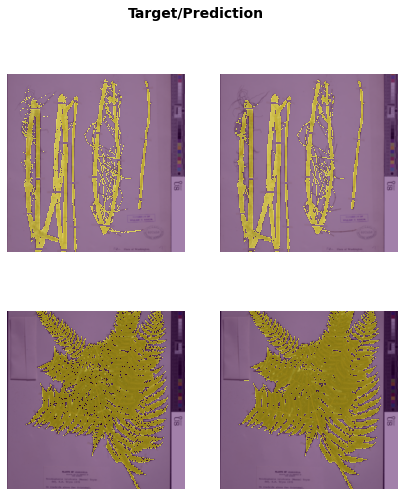

In [ ]:
segmenter.show_results(max_n=6, figsize=(7,8), vmin=0, vmax=1, cmap="viridis")

This looks really good! The top one misses some of the hairy bits coming off the top-right of the specimen. The bottom one over-predicts in the gaps of the specimen slightly. But overall, this is really good!